# Лабораторная работа №1

### работу выполнил Смирнов Андрей Сергеевич М3337


## Выгрузка данных из тензорфлоу и придание им числового вида

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from sklearn.preprocessing import StandardScaler

# Загрузка датасета CIFAR-10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
train_labels

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [2]:
train_len = 5000
test_len = 1000
train_images = train_images[:train_len]
train_labels = train_labels[:train_len]
test_images = test_images[-test_len:]
test_labels = test_labels[-test_len:]


# Предобработка данных
# Преобразование значений пикселей к диапазону от 0 до 1
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0


# Нормализация данных (стандартизация)
scaler = StandardScaler()
train_images = scaler.fit_transform(train_images.reshape(train_images.shape[0], -1)).reshape(train_images.shape)
test_images = scaler.transform(test_images.reshape(test_images.shape[0], -1)).reshape(test_images.shape)

# Вывод размеров данных
print("Размеры обучающей выборки:", train_images.shape, train_labels.shape)
print("Размеры тестовой выборки:", test_images.shape, test_labels.shape)

# Преобразование изображений в двумерные массивы
train_images_flat = train_images.reshape(train_images.shape[0], -1)
test_images_flat = test_images.reshape(test_images.shape[0], -1)
train_labels_flat = train_labels.flatten()
test_labels_flat = test_labels.flatten()
print(train_images_flat)
print(train_labels_flat)

Размеры обучающей выборки: (5000, 32, 32, 3) (5000, 1)
Размеры тестовой выборки: (1000, 32, 32, 3) (1000, 1)
[[-0.97621554 -1.0068297  -0.8550109  ... -0.06853879 -0.5380007
  -0.6391327 ]
 [ 0.3037721   0.54991555  0.6665136  ...  0.23622699  0.10691439
   0.43790096]
 [ 1.6646008   1.6057948   1.500898   ... -0.723785   -0.6323785
  -0.45962706]
 ...
 [ 0.4789283   0.36039874  0.1511586  ... -1.3028398  -0.75821555
  -0.45962706]
 [ 0.3037721   0.21149267 -0.09424865 ...  1.0133795   1.9000926
  -0.01086311]
 [-1.1648452  -1.4129372  -1.370366   ...  0.43432465  0.24848108
  -0.2202863 ]]
[6 9 9 ... 5 4 6]


## Реализация метода kNN

In [14]:
from scipy import stats
import math

from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd

class MyKNearestNeighbors:
    weights: np.ndarray = None
    kernels = {
        'uniform': lambda x: stats.uniform.pdf(x, loc=-1, scale=2),
        'gaussian': lambda x: 1/math.sqrt(2*math.pi)*math.exp(-(x**2/2)),
        'triangular': lambda x: max(0,1-abs(x)),
        'epanechnikov': lambda x: max(0, 0.75*(1-x**2))
    }
    metrics = ['manhattan', 'euclidean', 'cosine']
    xs: pd.DataFrame = None
    ys: np.ndarray = None
    n_classes: int = 0

    def __init__(
            self,
            n_neighbors: int = 3,
            window_type: str = 'non_fixed',
            window_param: float | None = None,
            metric: str = 'euclidean',
            weights: str = 'gaussian',
            leaf_size: int = 30
    ):
        self.n_neighbors = n_neighbors if not n_neighbors is None else 3
        self.window = window_param if window_type == 'fixed' else None
        self.leaf_size = leaf_size
        self.metric = metric
        self.kernel = self.kernels[weights]

    def fit(self, X, y, weights=None):
        self.xs = X
        self.ys = y
        self.cls_num = len(np.unique(y))
        self.weights = weights if weights is not None else np.array([1.0] * len(y))
        return self

    def predict(self, X):
        n_neighbors = self.n_neighbors + 1 if self.window is None else self.n_neighbors
        dists, ids = NearestNeighbors(n_neighbors=n_neighbors, metric=self.metric).fit(self.xs).kneighbors(X, n_neighbors=n_neighbors)
        
        cls = [self.ys[i] for i in ids]         # only for int one-dimension
        ws = [[self.weights[j] for j in i] for i in ids]

        length = len(X)
        results = np.array([0]*length)
        for i in range(length):
            d, c, w = dists[i], cls[i], ws[i]
            scores = [0]*self.cls_num
            
            for j in range(len(d)-1):
                kernel_arg = d[j]/(self.window if self.window else d[-1])
                scores[c[j]] += self.kernel(kernel_arg) * w[j]
            results[i] = scores.index(max(scores))

        return results

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Пример использования на своей модели и уже готовой библиотечной
for model in [MyKNearestNeighbors, KNeighborsClassifier]:
    # Создание и обучение модели
    knn = model(n_neighbors=3, weights='uniform', metric='euclidean')
    knn.fit(train_images_flat, train_labels_flat)
    
    # Предсказание меток для тестовых данных
    predicted_labels = knn.predict(test_images_flat)
    
    # Оценка точности предсказаний
    accuracy = accuracy_score(test_labels_flat, predicted_labels)
    print(f"Точность классификации модели {model}: {accuracy}")

Точность классификации модели <class '__main__.MyKNearestNeighbors'>: 0.254
Точность классификации модели <class 'sklearn.neighbors._classification.KNeighborsClassifier'>: 0.254


Как видно из результатов, точность классификации совпадают для нашей и библиотечной модели хотя бы для этих гиперпараметрах, а значит мы движемся в правильном направлении! Теперь давайте перейдем к этапу подбора гиперпараметров

## Подбор гиперпараметров
Для этого будем использовать библиотеку optuna

In [34]:
import optuna

def my_objective(trial):
    # Определение гиперпараметров для настройки
    # weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', MyKNearestNeighbors.metrics)
    kernel = trial.suggest_categorical('kernel', MyKNearestNeighbors.kernels.keys())
    window_type = trial.suggest_categorical('window_type', ['non_fixed', 'fixed'])
    window_param = trial.suggest_float('window_param', 0.01, 1) if window_type == 'fixed' else None
    n_neighbors = trial.suggest_int('n_neighbors', 1, 100) if window_type == 'non_fixed' else None
    
    knn = MyKNearestNeighbors(
        n_neighbors=n_neighbors, 
        weights=kernel, 
        metric=metric,
        window_type=window_type,
        window_param=window_param,
    )
    knn.fit(train_images_flat, train_labels_flat)
    y_pred = knn.predict(test_images_flat)
    return accuracy_score(test_labels_flat, y_pred)

# Создание объекта study для оптимизации гиперпараметров
study = optuna.create_study(direction='maximize')
study.optimize(my_objective, n_trials=100, show_progress_bar=True)

# Вывод лучших найденных значений гиперпараметров
best_params = study.best_params
print(f"Лучшие гиперпараметры для моей модели: {best_params}")

[I 2024-04-03 20:57:46,115] A new study created in memory with name: no-name-96ecf806-92af-4d0f-b24f-85fe95223e13


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-04-03 20:57:51,248] Trial 0 finished with value: 0.107 and parameters: {'metric': 'manhattan', 'kernel': 'triangular', 'window_type': 'fixed', 'window_param': 0.6112115951861521}. Best is trial 0 with value: 0.107.
[I 2024-04-03 20:57:55,344] Trial 1 finished with value: 0.107 and parameters: {'metric': 'manhattan', 'kernel': 'gaussian', 'window_type': 'fixed', 'window_param': 0.06281432285407615}. Best is trial 0 with value: 0.107.
[I 2024-04-03 20:58:03,385] Trial 2 finished with value: 0.247 and parameters: {'metric': 'euclidean', 'kernel': 'uniform', 'window_type': 'non_fixed', 'n_neighbors': 93}. Best is trial 2 with value: 0.247.
[I 2024-04-03 20:58:07,772] Trial 3 finished with value: 0.107 and parameters: {'metric': 'manhattan', 'kernel': 'uniform', 'window_type': 'fixed', 'window_param': 0.7739180371982081}. Best is trial 2 with value: 0.247.
[I 2024-04-03 20:58:08,457] Trial 4 finished with value: 0.107 and parameters: {'metric': 'euclidean', 'kernel': 'triangular', '

In [35]:
import optuna

def lib_objective(trial):
    # Определение гиперпараметров для настройки
    n_neighbors = trial.suggest_int('n_neighbors', 1, 10)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    
    knn = KNeighborsClassifier(
        n_neighbors=n_neighbors, 
        weights=weights, 
    )
    knn.fit(train_images_flat, train_labels_flat)
    y_pred = knn.predict(test_images_flat)
    return accuracy_score(test_labels_flat, y_pred)

# Создание объекта study для оптимизации гиперпараметров
study = optuna.create_study(direction='maximize')
study.optimize(lib_objective, n_trials=100, show_progress_bar=True)

# Вывод лучших найденных значений гиперпараметров
best_params = study.best_params
print(f"Лучшие гиперпараметры для библиотечной модели: {best_params}")

[I 2024-04-03 20:59:35,845] A new study created in memory with name: no-name-8593853c-3a4a-40a2-91b9-a0f0eb32be7f


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-04-03 20:59:36,319] Trial 0 finished with value: 0.259 and parameters: {'n_neighbors': 1, 'weights': 'distance'}. Best is trial 0 with value: 0.259.
[I 2024-04-03 20:59:36,748] Trial 1 finished with value: 0.259 and parameters: {'n_neighbors': 2, 'weights': 'distance'}. Best is trial 0 with value: 0.259.
[I 2024-04-03 20:59:37,178] Trial 2 finished with value: 0.268 and parameters: {'n_neighbors': 4, 'weights': 'distance'}. Best is trial 2 with value: 0.268.
[I 2024-04-03 20:59:37,631] Trial 3 finished with value: 0.268 and parameters: {'n_neighbors': 4, 'weights': 'distance'}. Best is trial 2 with value: 0.268.
[I 2024-04-03 20:59:38,086] Trial 4 finished with value: 0.258 and parameters: {'n_neighbors': 9, 'weights': 'uniform'}. Best is trial 2 with value: 0.268.
[I 2024-04-03 20:59:38,519] Trial 5 finished with value: 0.265 and parameters: {'n_neighbors': 4, 'weights': 'uniform'}. Best is trial 2 with value: 0.268.
[I 2024-04-03 20:59:38,980] Trial 6 finished with value: 0.2

## Графики в зависимости от n_neighbours и размера окна

In [9]:
def get_my_accuracy_by_neighbors(n_neighbors, images, labels):
    knn = MyKNearestNeighbors(
        n_neighbors=n_neighbors, 
        weights='epanechnikov', 
        metric='cosine',
        window_type='non_fixed',
    )
    knn.fit(train_images_flat, train_labels_flat)
    y_pred = knn.predict(images)
    return accuracy_score(labels, y_pred)

def get_lib_accuracy_by_neighbors(n_neighbors, images, labels):
    knn = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights='distance',
    )
    knn.fit(train_images_flat, train_labels_flat)
    y_pred = knn.predict(images)
    return accuracy_score(labels, y_pred)

def get_my_accuracy_by_window_size(window_size, images, labels):
    knn = MyKNearestNeighbors(
        n_neighbors=15, 
        weights='epanechnikov', 
        metric='cosine',
        window_type='fixed',
        window_param=window_size,
    )
    knn.fit(train_images_flat, train_labels_flat)
    y_pred = knn.predict(images)
    return accuracy_score(labels, y_pred)

### Для n_neighbors

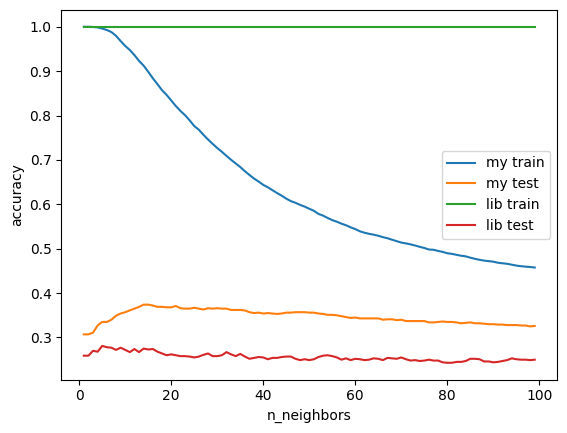

In [37]:
import matplotlib.pyplot as plt

neighbors_range = [k for k in range(1, 100)]

my_train = [get_my_accuracy_by_neighbors(k, train_images_flat, train_labels_flat) for k in neighbors_range]
lib_train = [get_lib_accuracy_by_neighbors(k, train_images_flat, train_labels_flat) for k in neighbors_range]
my_test = [get_my_accuracy_by_neighbors(k, test_images_flat, test_labels_flat) for k in neighbors_range]
lib_test = [get_lib_accuracy_by_neighbors(k, test_images_flat, test_labels_flat) for k in neighbors_range]

plt.plot(neighbors_range, my_train, label='my train')
plt.plot(neighbors_range, my_test, label='my test')
plt.plot(neighbors_range, lib_train, label='lib train')
plt.plot(neighbors_range, lib_test, label='lib test')
plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('accuracy')
plt.show()

### Для размера окна

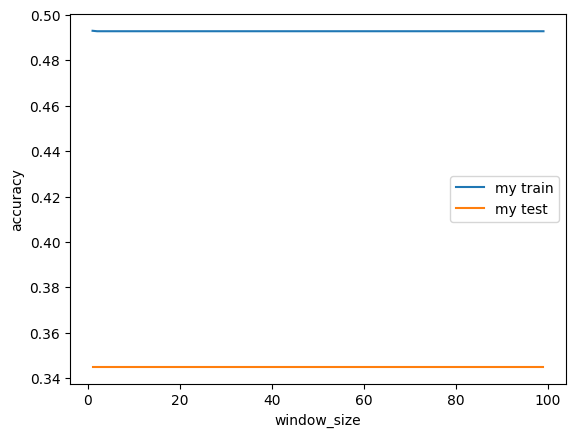

In [12]:
window_sizes = [k * 0.01 for k in range(1, 100)]
my_train = [get_my_accuracy_by_window_size(k, train_images_flat, train_labels_flat) for k in neighbors_range]
my_test = [get_my_accuracy_by_window_size(k, test_images_flat, test_labels_flat) for k in neighbors_range]


plt.plot(neighbors_range, my_train, label='my train')
plt.plot(neighbors_range, my_test, label='my test')
plt.legend()
plt.xlabel('window_size')
plt.ylabel('accuracy')
plt.show()

## Поиск аномалий

## Реализация LOWESS

In [4]:
def my_lowess(X, y, knn):
    anomaly_idxs = []
    for i in range(len(X)):
        X1 = np.delete(X, i, axis=0)
        y1 = np.delete(y, i, axis=0)
        knn.fit(X1, y1)
        y_pred = knn.predict([X[i]])[0]
        # print(f"i = {i}, y_pred={y_pred}, y[i]={y[i]}")
        if y_pred != y[i]:
            anomaly_idxs.append(i)
    weights = np.array([1.] * len(X))
    weights[anomaly_idxs] *= 0.1
    return weights

### Реализация с моим knn

In [16]:
knn = MyKNearestNeighbors(
        n_neighbors=16, 
        weights='triangular',  
        metric='cosine',
        window_type='non_fixed',
    )

In [5]:
train_weights = my_lowess(
    train_images_flat, 
    train_labels_flat, 
    knn
)
train_weights

array([1. , 0.1, 1. , ..., 0.1, 0.1, 0.1])

In [17]:
knn.fit(train_images_flat, train_labels_flat, weights=train_weights)
y_pred = knn.predict(test_images_flat)
print(f"with weights = {accuracy_score(test_labels_flat, y_pred)}")

knn.fit(train_images_flat, train_labels_flat)
y_pred = knn.predict(test_images_flat)
print(f"without weights = {accuracy_score(test_labels_flat, y_pred)}")

with weights = 0.332
without weights = 0.374


### Реализация с библиотечным knn

In [18]:
knn1 = KNeighborsClassifier(
        n_neighbors=3,
    )

In [19]:
train_weights1 = my_lowess(
    train_images_flat, 
    train_labels_flat, 
    knn1
)
train_weights1

array([1. , 0.1, 0.1, ..., 0.1, 0.1, 0.1])

In [20]:
sampled_X = []
sampled_y = []
for i in range(len(train_images_flat)):
    if train_weights1[i] == 1:
        sampled_X.append(train_images_flat[i])
        sampled_y.append(train_labels[i])
        
sampled_X_train = np.array(sampled_X)
sampled_y_train = np.array(sampled_y)

In [24]:
knn1.fit(sampled_X_train, sampled_y_train)
y_pred = knn1.predict(test_images_flat)
print(f"with sampling = {accuracy_score(test_labels_flat, y_pred)}")

knn1.fit(train_images_flat, train_labels_flat)
y_pred = knn1.predict(test_images_flat)
print(f"without sampling = {accuracy_score(test_labels_flat, y_pred)}")

C:\Users\DNS\PycharmProjects\lab1-knn-sandrew-uj\venv\lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


with sampling = 0.212
without sampling = 0.254
